<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher_New/blob/main/WorksDec_28th_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#optPhotoFiles; matched samplesを抽出する。
これまでにRA群、nonRA群ともに画像の前処理を行って、1.不良画像の排除、2. フォーマットの統一、3. 背景の消去、4. 画像の上下左右の統一を済ませた。

今後、ViTのトレーニングを開始するにあたって、RA群とnonRA群の年齢構成の相違が問題となる。これを解決するために年齢をマッチさせたサンプルをRA群およびnonRA群から1:1で無作為に抽出する。

###GoogleDriveのマウント

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###必要なライブラリのインポート
この工程ではcsvファイルの操作を行うためにpandasを使用する。統計量の計算にはnumpyが必要となる。また、ヒストグラムの描画のためにmatplotlibを使用する。

In [16]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

###データの読み込み。
先日作成したRA群の情報を記載した"optPhotoTable_RA.csv"とnonRA群の情報を記載した"optPhotoTable_control.csv"をpandasのread_csvを使用してデータフレームとして読み込む。

In [17]:
# データの読み込み
ra_df = pd.read_csv("/content/drive/MyDrive/2023.12.27/OptPhotoFiles/optPhotoTable_RA.csv")
control_df = pd.read_csv("/content/drive/MyDrive/2023.12.27/OptPhotoFiles/optPhotoTable_control.csv")

###基本的な統計量の算出
ra_dfとcontrol_dfの基本統計量として、年齢の平均値と標準偏差、中間値と４分位を求める。

In [18]:
# 統計量の計算
def get_statistics(df, column_name):
    mean = df[column_name].mean()
    median = df[column_name].median()
    std = df[column_name].std()
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)

    return mean, median, std, q1, q3

mean_ra, median_ra, std_ra, q1_ra, q3_ra = get_statistics(ra_df, "age")
mean_control, median_control, std_control, q1_control, q3_control = get_statistics(control_df, "age")

# 結果の表示
print(f"RA group - Mean age: {mean_ra:.2f}, Median age: {median_ra}, Standard Deviation: {std_ra:.2f}, Q1: {q1_ra}, Q3: {q3_ra}")
print(f"Control group - Mean age: {mean_control:.2f}, Median age: {median_control}, Standard Deviation: {std_control:.2f}, Q1: {q1_control}, Q3: {q3_control}")

RA group - Mean age: 69.20, Median age: 71.0, Standard Deviation: 13.48, Q1: 62.25, Q3: 80.0
Control group - Mean age: 39.26, Median age: 37.0, Standard Deviation: 12.34, Q1: 30.0, Q3: 47.0


###度数分布表の作成
ra_dfとcontrol_dfの各群における年齢の分布を把握するため、５歳刻みの年齢の度数分布表を算出する。

In [19]:
# 5歳刻みの度数分布
bins = list(range(10, 105, 5))
ra_hist_values, _ = np.histogram(ra_df["age"], bins=bins)
control_hist_values, _ = np.histogram(control_df["age"], bins=bins)

print("RA group age distribution:")
for i in range(len(bins)-1):
    print(f"{bins[i]}-{bins[i+1]-1}: {ra_hist_values[i]}")

print("\nControl group age distribution:")
for i in range(len(bins)-1):
    print(f"{bins[i]}-{bins[i+1]-1}: {control_hist_values[i]}")

RA group age distribution:
10-14: 0
15-19: 0
20-24: 2
25-29: 2
30-34: 8
35-39: 8
40-44: 8
45-49: 32
50-54: 34
55-59: 30
60-64: 56
65-69: 98
70-74: 84
75-79: 82
80-84: 98
85-89: 38
90-94: 16
95-99: 2

Control group age distribution:
10-14: 0
15-19: 55
20-24: 193
25-29: 311
30-34: 413
35-39: 389
40-44: 312
45-49: 301
50-54: 179
55-59: 95
60-64: 49
65-69: 95
70-74: 14
75-79: 12
80-84: 6
85-89: 2
90-94: 0
95-99: 0


###各群の年齢のヒストグラムを表示する。
ra_df, control_dfの年齢分布をより直感的に把握するため、各群の年齢分布を５歳刻みのヒストグラムとして表示する。

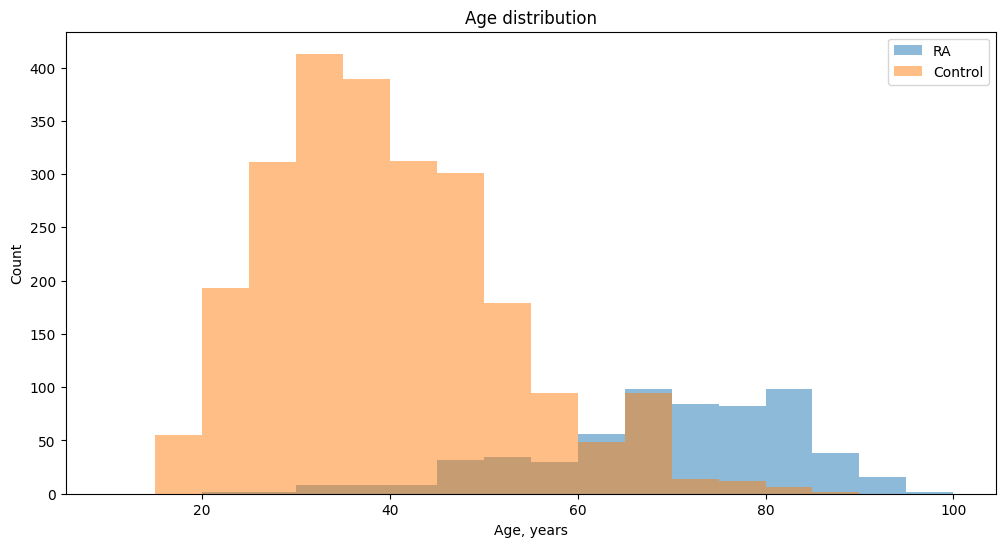

In [20]:
# ヒストグラムの表示
plt.figure(figsize=(12, 6))
plt.hist(ra_df["age"], bins=bins, alpha=0.5, label="RA")
plt.hist(control_df["age"], bins=bins, alpha=0.5, label="Control")
plt.title("Age distribution")
plt.xlabel("Age, years")
plt.ylabel("Count")
plt.legend()
plt.show()

###性別の度数分布を確認する。
つぎに、ra_dfとcontrol_dfの性別の比率を確認する。両群ともに1がfemale, 0がmaleである。

In [21]:
# femaleの度数
ra_female_counts = ra_df["sex"].value_counts()
control_female_counts = control_df["sex"].value_counts()

print(f"RA group - Female counts:\n{ra_female_counts}")
print(f"Control group - Female counts:\n{control_female_counts}")

RA group - Female counts:
1    432
0    166
Name: sex, dtype: int64
Control group - Female counts:
1    1311
0    1115
Name: sex, dtype: int64


In [22]:
# 年齢を5歳刻みにカテゴライズする関数
def categorize_age(age):
    return (age // 5) * 5

# 年齢カテゴリの列を追加
ra_df['age_category'] = ra_df['age'].apply(categorize_age)
control_df['age_category'] = control_df['age'].apply(categorize_age)

matched_samples = []

# 5歳刻みのカテゴリごとにループ
for age_cat in range(5, 105, 5):
    for gender in [0, 1]:
        ra_sample = ra_df[(ra_df['age_category'] == age_cat) & (ra_df['sex'] == gender)]
        control_sample = control_df[(control_df['age_category'] == age_cat) & (control_df['sex'] == gender)]

        # 最小のサイズに合わせる
        sample_size = min(len(ra_sample), len(control_sample))

        # サンプリング
        ra_sample = ra_sample.sample(n=sample_size, random_state=42)
        control_sample = control_sample.sample(n=sample_size, random_state=42)

        # 結果をリストに追加
        matched_samples.extend([ra_sample, control_sample])

# 全てのサンプルを統合
matched_df = pd.concat(matched_samples, ignore_index=True)

# 結果の表示
print(matched_df.head())
print(matched_df.shape)

   age  sex  RA  arthralgia                   filename  age_category
0   20    1   1           0       RA_Left_Hand_162.jpg            20
1   20    1   1           0      RA_Right_Hand_162.jpg            20
2   23    1   0           0   nonRA_right_hand_239.jpg            20
3   24    1   0           0  nonRA_right_hand_1073.jpg            20
4   29    1   1           0       RA_Left_Hand_186.jpg            25
(494, 6)


In [23]:
# matched_dfをCSVとして保存
save_path = "/content/drive/MyDrive/2023.12.27/OptPhotoFiles/matched_samples.csv"
matched_df.to_csv(save_path, index=False)
print(f"Saved matched_df to {save_path}")

Saved matched_df to /content/drive/MyDrive/2023.12.27/OptPhotoFiles/matched_samples.csv
